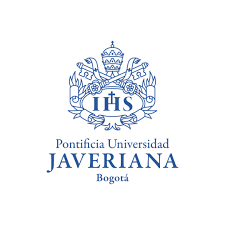
***Pontificia Universidad Javeriana***
# **Procesamiento de Alto Volumen de Datos**

Autor: Ricardo Hurtado

Fecha: 19 de marzo 2025




**Objetivo**: Uso de MLLIB como Biblioteca IA en PySpark, para la creación de modelos de predicción.

La calidad del agua representa la calidad de vida de los seres humanos. El agua es junto con el aire, las necesidades más importantes para la vida. La definición popular de *calidad del agua son sus características físicas, químicas y biológicas del agua* **[1]**.
 El presente estudio tiene como objetivo el análisis de la calidad del agua en la India, como metodología de trabajo sobre estudios de comportamiento de contaminación y sus modelos en ML para la predicción.

____________________________________________________

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## !pip install pyspark

In [4]:
import os #  trabajar con manejo de archivos
import pandas as pd # trabajar con datasets y tablas
import numpy as np  #Operaciones Matematicas
%matplotlib inline
import matplotlib.pyplot as plt #Graficas
import seaborn as sns # Graficas
import geopandas as gpd   #Trabajar con Datos Geograficos y Mapas
import warnings
warnings.filterwarnings("ignore")

#Spark es utilizado para manejar un Gran Volumen de Datos
from pylab import * #Importa todo de pylab, Matematicas y Graficos
from pyspark.sql.functions import input_file_name, mean, col, split, regexp_extract, when, lit, isnan, count
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext


from pyspark.sql.types import *
import pyspark.sql.functions as F
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .getOrCreate()
sqlContext = SQLContext(sc)

**Cargar los datos (en la asignación se encuentran los datos a usar)**

In [5]:
## Se conecta con el drive de google, para tener los datos cerca
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#Se montan las Rutas de los Archivos de datos con lo que vamos a trabajar

rutaCSV = "/content/drive/MyDrive/waterquality.csv"
rutaIndia = "/content/drive/MyDrive/Colab Notebooks/Indian_States.shp"

In [7]:
#Importar OS de Google
os.environ['SHAPE_RESTORE_SHX'] = 'YES'

In [8]:
#Se crea un dataset de Spark para el Archivo.csv y uno GeoPandas para el archivo con datos geograficos

df00 = spark.read.csv(rutaCSV, header=True, inferSchema=True)
gpdf00 = gpd.read_file(rutaIndia)

In [9]:
## Se hace inspeccion sobre los datos CSV
df00.show(5)

+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|TOTAL_COLIFORM|
+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|         735|3.4|                  2|             3|            73|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|  6|8.0|         270|3.1|                  2|            72|           182|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|         355|4.2|                  9|            59|           133|
|        2179|GODAVARI RIVER AT...|MAHARASHTRA|24.8|5.5|7.8|         371|5.6|               3.55|            90|           283|
|        2183|GODAVARI RIVER AT...|MAHARASHTRA|25.7|5.7|7.9|         294|3.2|               2.69|       

# **Análisis y Preparación de Datos: Archivo CSV**
Se presentan los datos que contienen los parámetros de diferentes rios en la India. Cada dato o parámetro es el promedio de valores medidos sobre un período de tiempo. Los datos han sido extraidos de la web oficial de datos de la India.


- Tipo de Datos: Coherencia de tipo de datos, transformación.
- Columnas: Conocimiento de columnas, eliminación de necesarias
- Análisis de Datos Nulos o Imposibles: Conocimiento cantidad, acción.

#Tipos de Datos: conocimiento y análisis

In [10]:
df00.columns

['STATION CODE',
 'LOCATIONS',
 'STATE',
 'TEMP',
 'DO',
 'pH',
 'CONDUCTIVITY',
 'BOD',
 'NITRATE_N_NITRITE_N',
 'FECAL_COLIFORM',
 'TOTAL_COLIFORM']

Se presentan los parámetros y sus definiciones de la calidad del agua en las regiones de la India. La definición de las fuentes, impactos, efectos y métodos de medida de la base de datos: no son contempladas en el presente estudio. Las definiciones de los parámetros dados por la base de datos son extraidos de **[2]**.

- STATION CODE: Código de estación
- LOCATIONS: Ubicación de estación (Ubicación del Rio)
- STATE: Estado/Lugar de la India
- TEMP: Temperatura promedio del agua (°C)
- DO: Oxigeno Disuelto (mg/L). Concentraciones altas de oxigeno disuelto representa mejor calidad del agua.
- pH: Se define como el logaritmo negativo de la concentración de hidrógeno. Número adimensional que indica la acidez o base de una solución **[3]**.
- CONDUCTIVITY: Mide la habilidad de una solución conducir corriente electrica **[4]**. El agua pura no es buen conductor de electricidad **[5]**.
- BOD: Las bacterias y otros microorganismos utilizan sustancias orgánicas como alimento (Demanda Bioquímica de Oxigeno). A medida que metabolizan la materia orgánica, consumen oxígeno **[4]**. Mayor cantidad de material orgánico en el agua, mayor valor de BOD.
- 'NITRATE_N_NITRITE_N': Nitrito y Nitrato Nitrogeno. Altas concentraciones de N en la superficie del agua puede estimular el rápido crecimiento de algas las cuales degradan la calidad del agua (mg/L). **[4]**.
- 'FECAL_COLIFORM': Promedio de bacterias coliforms (excresiones) **[6]** .
-  'TOTAL_COLIFORM: Cantidad total de coliformes. Se retira del dataset ya que no aporta información promedio sobre los datos.

In [11]:
df00.dtypes

[('STATION CODE', 'int'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'string'),
 ('DO', 'string'),
 ('pH', 'double'),
 ('CONDUCTIVITY', 'string'),
 ('BOD', 'string'),
 ('NITRATE_N_NITRITE_N', 'string'),
 ('FECAL_COLIFORM', 'string'),
 ('TOTAL_COLIFORM', 'string')]

#Tipo de Datos
* Se observa que los datos se encuentran en tipo string. Se procede a cambiar a tipo de datos double.

In [12]:
#Cambio de tipo de variable
df00 = df00.withColumn('TEMP', df00['TEMP'].cast(FloatType()))
df00 = df00.withColumn('pH', df00['pH'].cast(FloatType()))
df00 = df00.withColumn('DO', df00['DO'].cast(FloatType()))
df00 = df00.withColumn('CONDUCTIVITY', df00['CONDUCTIVITY'].cast(FloatType()))
df00 = df00.withColumn('NITRATE_N_NITRITE_N', df00['NITRATE_N_NITRITE_N'].cast(FloatType()))
df00 = df00.withColumn('FECAL_COLIFORM', df00['FECAL_COLIFORM'].cast(FloatType()))
df00 = df00.withColumn('BOD', df00['BOD'].cast(FloatType()))
df00 = df00.withColumn('TOTAL_COLIFORM', df00['TOTAL_COLIFORM'].cast(FloatType()))
df00.dtypes

[('STATION CODE', 'int'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'float'),
 ('DO', 'float'),
 ('pH', 'float'),
 ('CONDUCTIVITY', 'float'),
 ('BOD', 'float'),
 ('NITRATE_N_NITRITE_N', 'float'),
 ('FECAL_COLIFORM', 'float'),
 ('TOTAL_COLIFORM', 'float')]

In [13]:
# Se elimina TOTAL_COLIFORM, no aporta a la investigación
df00 = df00.drop('TOTAL_COLIFORM')
df00.columns

['STATION CODE',
 'LOCATIONS',
 'STATE',
 'TEMP',
 'DO',
 'pH',
 'CONDUCTIVITY',
 'BOD',
 'NITRATE_N_NITRITE_N',
 'FECAL_COLIFORM']

# Cantidad de Datos Núlos o Imposibles.

In [14]:
df00.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df00.columns]).show()

+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+
|STATION CODE|LOCATIONS|STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+
|           0|        0|    0|   5|  2|  0|          30|  6|                  2|            82|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+



Se requiere limpiar los datos de los nulos o imposibles. Para ello se hará una tabla (ofrece mejor rendiminento para consultas SQL: Procesamiento de Alto Volumen de Datos) y posteriormente una consulta sql para eliminar los datos que No se requieren. A continuación los pasos:
* Se crea la tabla
* Se hace la consulta a la Tabla



In [15]:
df00.createOrReplaceTempView("df00_sql")

In [16]:
##Se hace la consulta, que retorna el df00 limpio, que se llamará df01
df01 = spark.sql('''Select * from df00_sql where TEMP is not null and
                    DO is not null and
                    pH is not null and
                    CONDUCTIVITY is not null and
                    BOD is not null and
                    NITRATE_N_NITRITE_N is not null and
                    FECAL_COLIFORM is not null''')

* Se verifica la eliminación de Datos Nulos o Imposibles

In [17]:
df01.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df01.columns]).show()

+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+
|STATION CODE|LOCATIONS|STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+
|           0|        0|    0|   0|  0|  0|           0|  0|                  0|             0|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+



* Se presenta información estadística de las columnas

In [18]:
for col in df01.columns:
  df01.describe([col]).show()

+-------+------------------+
|summary|      STATION CODE|
+-------+------------------+
|  count|               447|
|   mean|2056.6196868008947|
| stddev| 750.6013394156962|
|    min|                11|
|    max|              3330|
+-------+------------------+

+-------+-------------------+
|summary|          LOCATIONS|
+-------+-------------------+
|  count|                447|
|   mean|               NULL|
| stddev|               NULL|
|    min|          AHMEDABAD|
|    max|ZUARI AT PANCHAWADI|
+-------+-------------------+

+-------+--------------+
|summary|         STATE|
+-------+--------------+
|  count|           447|
|   mean|          NULL|
| stddev|          NULL|
|    min|ANDHRA PRADESH|
|    max|   WEST BENGAL|
+-------+--------------+

+-------+-----------------+
|summary|             TEMP|
+-------+-----------------+
|  count|              447|
|   mean|25.49843395369698|
| stddev| 3.31128283673611|
|    min|             10.5|
|    max|             33.8|
+-------+--------

#Visualización de los Datos
* Para cada parámetro de concentración promedio, se hará una consulta SQL desde la tabla temporal, y posteriormente se un RDD con una *función lambda* para colectar los datos (vector de datos).
* RDD (Resilient Distributed Dataset) es una estructura de datos de Apache Spark que permite procesar datos en paralelo. Los RDD son la principal abstracción de datos de Spark y se encuentran en el núcleo del sistema de computación.

* Visualización de concentraciones promedio de **pH** con **Oxigeno Disuelto**

In [19]:
#Creacion de tablas con datos limpios para visualizarlos
df01.createOrReplaceTempView("df01_sql")

In [20]:
#Hacer los vectores de la tabla para cada parametro
STATE_N = spark.sql('''Select STATE from df01_sql''')
STATE_N = STATE_N.rdd.map(lambda fila: fila.STATE).collect()
DO_parametro = spark.sql('''Select DO from df01_sql''')
DO_parametro = DO_parametro.rdd.map(lambda fila: fila.DO).collect()
pH_parametro = spark.sql('''Select pH from df01_sql''')
pH_parametro = pH_parametro.rdd.map(lambda fila: fila.pH).collect()
COND_parametro = spark.sql('''Select CONDUCTIVITY from df01_sql''')
COND_parametro = COND_parametro.rdd.map(lambda fila: fila.CONDUCTIVITY).collect()
BOD_parametro = spark.sql('''Select BOD from df01_sql''')
BOD_parametro = BOD_parametro.rdd.map(lambda fila: fila.BOD).collect()
NN_parametro = spark.sql('''Select NITRATE_N_NITRITE_N from df01_sql''')
NN_parametro = NN_parametro.rdd.map(lambda fila: fila.NITRATE_N_NITRITE_N).collect()
FC_parametro = spark.sql('''Select FECAL_COLIFORM from df01_sql''')
FC_parametro = FC_parametro.rdd.map(lambda fila: fila.FECAL_COLIFORM).collect()


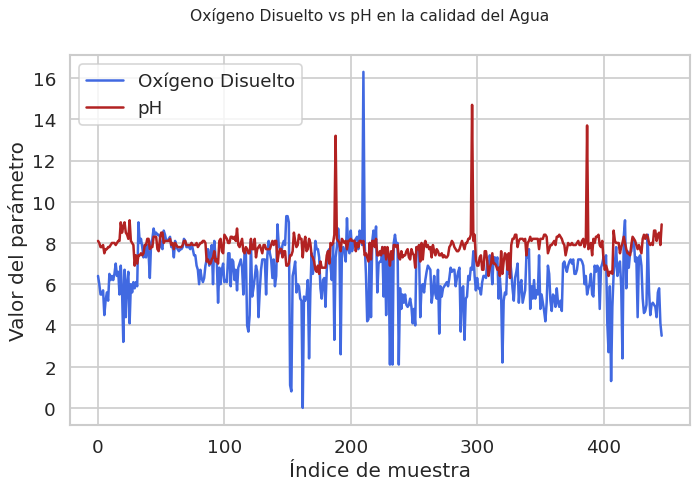

In [95]:
##Grafica que compara el OXIGENO DISUELTO y el pH en el agua
tam = len(DO_parametro)
fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

# Graficar los dos parámetros en una misma graficas
ax1.plot(range(0, tam), DO_parametro, color='royalblue', label='Oxígeno Disuelto')
ax1.plot(range(0, tam), pH_parametro, color='firebrick', label='pH')

fig.suptitle('Oxígeno Disuelto vs pH en la calidad del Agua', fontsize=14)
ax1.set_xlabel('Índice de muestra')
ax1.set_ylabel('Valor del parámetro')
legend = ax1.legend()

plt.show()

El pH se mantiene dentro de un rango razonable para agua potable (entre 6.5 y 8.5 en la escal de ph), con 3 picos en los que el agua se vuelve Alkalina por encima del rango recomendable. Se puede observar que al ser mayormente estable la acidez y alcalinidad del agua no cambia mucho entre muestras. [7]

por el contario el Oxigeno Disuelto aparenta ser muy inestable llegando a estar en niveles muy bajos o muy alto, en la mayoria de casos el Oxigeno disuelto no suele tener efectos negativos en el consumo humano sin embargo si podria afectar a la vida nativa de las fuentes de agua. [2]

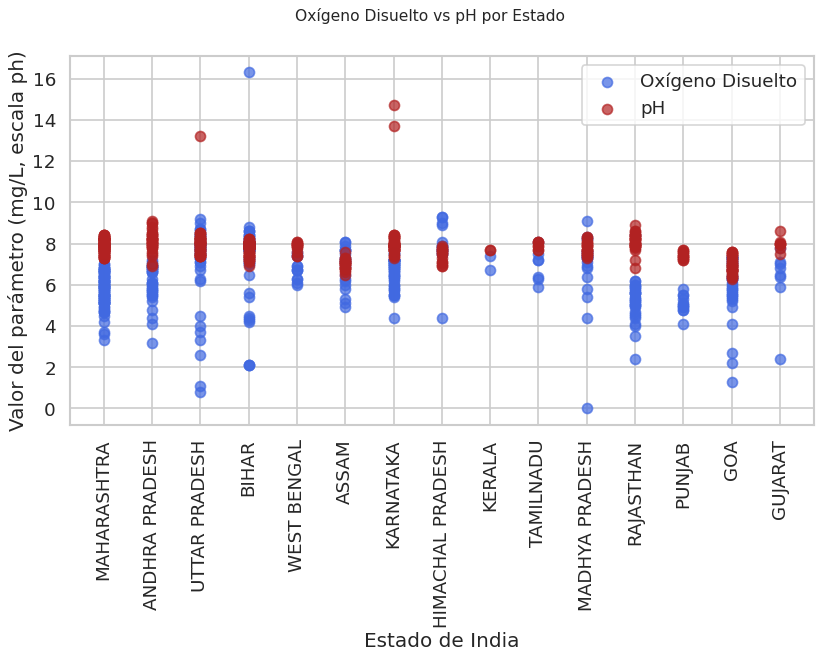

In [94]:
tam = len(DO_parametro)
fig, ax1 = plt.subplots(figsize=(12, 6), dpi=80)

# Graficar puntos con puntos en lugar de lineas Y Utilizando estados en lugar de el indice
ax1.scatter(STATE_N, DO_parametro, color='royalblue', label='Oxígeno Disuelto', alpha=0.7)
ax1.scatter(STATE_N, pH_parametro, color='firebrick', label='pH', alpha=0.7)

# Título y ejes
fig.suptitle('Oxígeno Disuelto vs pH por Estado', fontsize=14)
ax1.set_xlabel('Estado de India')
ax1.set_ylabel('Valor del parámetro (mg/L, escala ph)')

# Rotar etiquetas del eje X para que no se encimen
plt.xticks(rotation=90)

ax1.legend()
plt.grid(True)

plt.show()

En este grafico podemos ver los casos individuales en los que ocurren los picos y el estado en el que ocurrieron
podemos ver que los estados en los que ocurrio las situaciones de alto ph/ alkalinidad fueron ANDHRA PRADESH y KARNATAKA lo cual podria indicar situaciones de polución en estos estados.

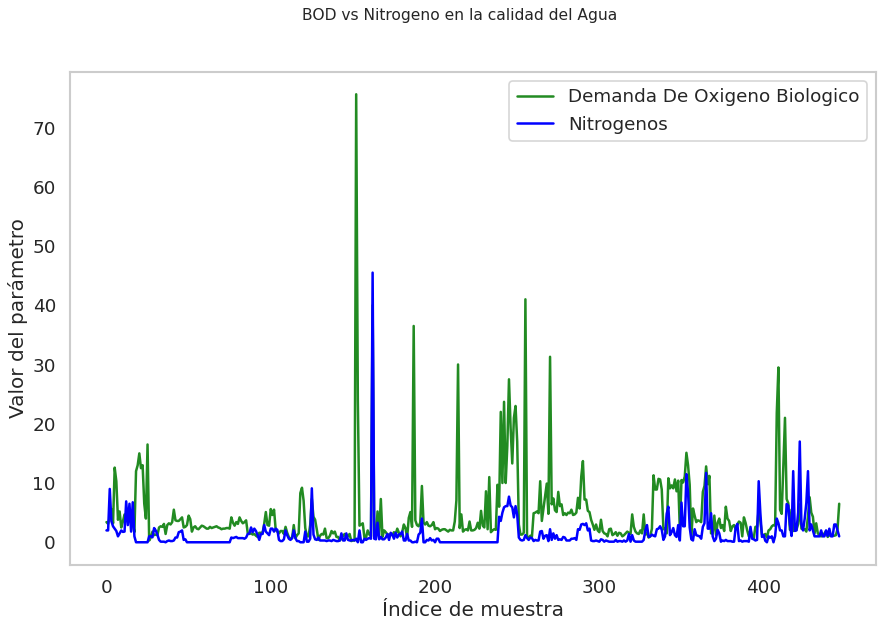

In [96]:
## Grafica parametros BOD y Nitrogenos

fig, ax1 = plt.subplots(num=None, figsize=(13, 8), dpi=80, facecolor='w', edgecolor='k')
ax1.plot(range(0, tam), BOD_parametro, color='forestgreen', label='Demanda De Oxigeno Biologico')
ax1.plot(range(0, tam), NN_parametro, color='blue', label='Nitrogenos')
fig.suptitle('BOD vs Nitrogeno en la calidad del Agua', fontsize=14)
ax1.set_xlabel('Índice de muestra')
ax1.set_ylabel('Valor del parámetro')
legend = ax1.legend()
plt.grid()

plt.show()

en esta grafica Tambien se puende Observar varios picos Anomalos en Ambos parametros lo cual nos indica un gran numero de microorganismos descomponiendo materia en el agua, lo cual es probablemente causado por contaminantes externos

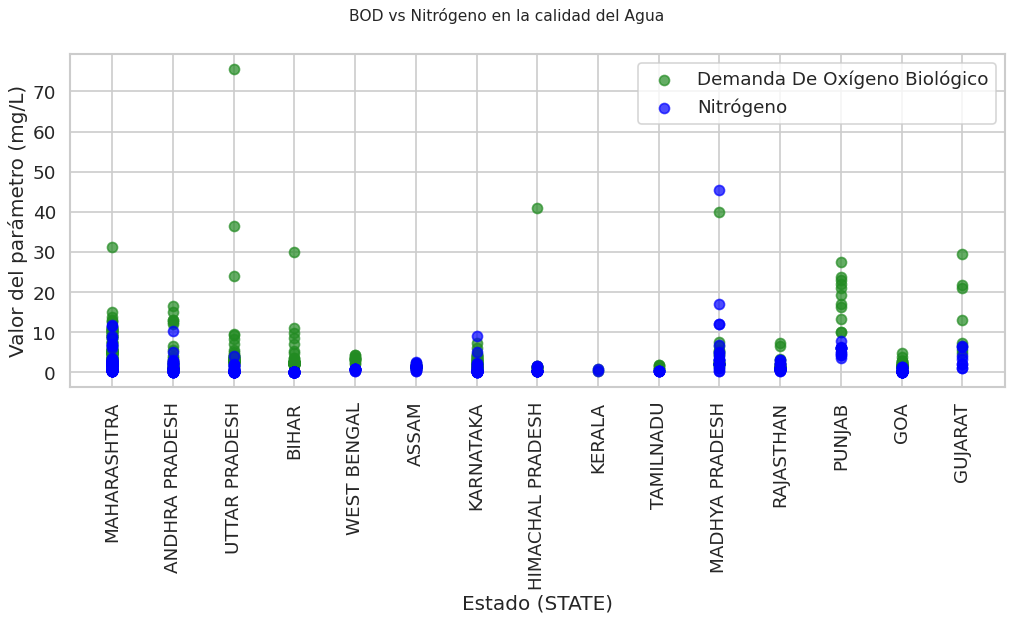

In [97]:
# Gráfica de BOD y Nitrógeno como puntos

fig, ax1 = plt.subplots(figsize=(13, 8), dpi=80)

# Gráfico de puntos
ax1.scatter(STATE_N, BOD_parametro, color='forestgreen', label='Demanda De Oxígeno Biológico', alpha=0.7)
ax1.scatter(STATE_N, NN_parametro, color='blue', label='Nitrógeno', alpha=0.7)

fig.suptitle('BOD vs Nitrógeno en la calidad del Agua', fontsize=14)
ax1.set_xlabel('Estado (STATE)')
ax1.set_ylabel('Valor del parámetro (mg/L)')
plt.xticks(rotation=90)
ax1.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

Podemos Observar los estados en lo que ocurren mayormente estos picos, podemos ver que en la mayoria de estados el nitrogeno suele mantenerse estable.

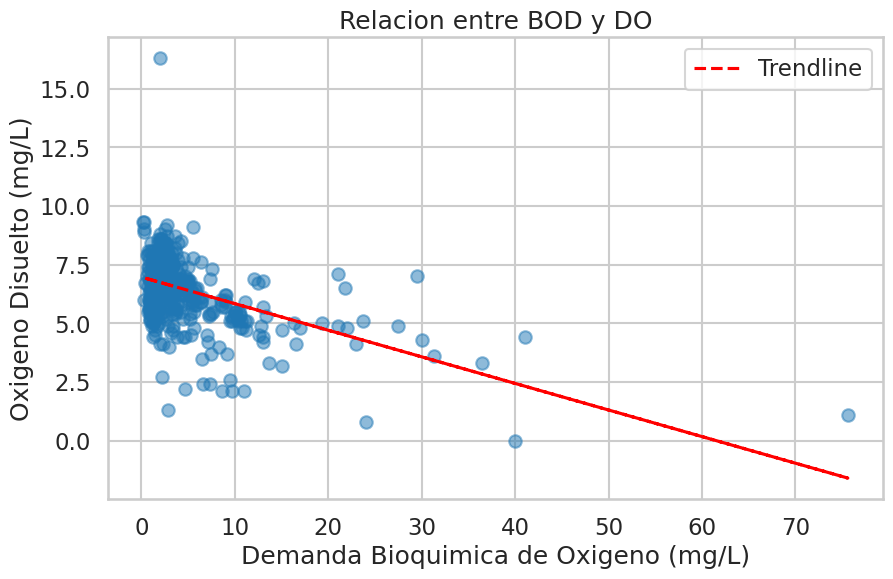

In [98]:
##grafica que compare el DO con el BOD para visualiar si un aumento en el BOD disminuye el DO
tam = len(DO_parametro)

plt.figure(figsize=(10, 6))
plt.scatter(BOD_parametro, DO_parametro, alpha=0.5)
plt.xlabel("Demanda Bioquimica de Oxigeno (mg/L)")
plt.ylabel("Oxigeno Disuelto (mg/L)")
plt.title("Relacion entre BOD y DO")
plt.grid(True)


L = np.polyfit(BOD_parametro, DO_parametro, 1)
Linea_ajuste= np.poly1d(L)
plt.plot(BOD_parametro, Linea_ajuste(BOD_parametro), "r--", label="Trendline")
plt.legend()


plt.show()


Podemos ver que entre mayor Consumo Biologico de de Oxigeno el Oxigeno Disuelto disminuye, lo cual corresponde a lo observado en las graficas anteirores con respecto a las graficas en las cuales estados con mayor Demanda de oxigeno tenian instancias con menor oxigeno disuelto.

Al tener muchos casos con alto BOD podria indicar la razon por la que el DO es poco estable mayormente bajo.

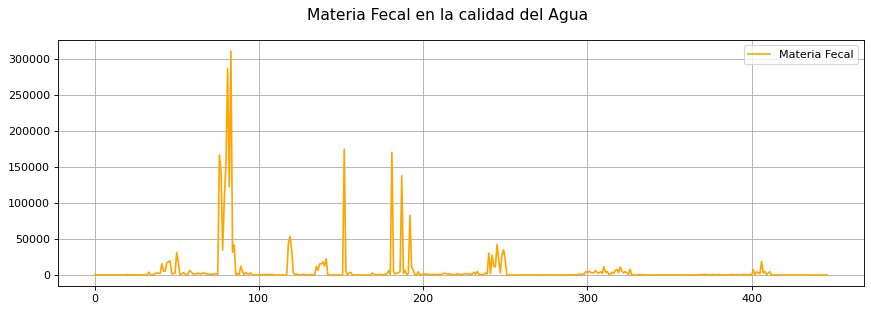

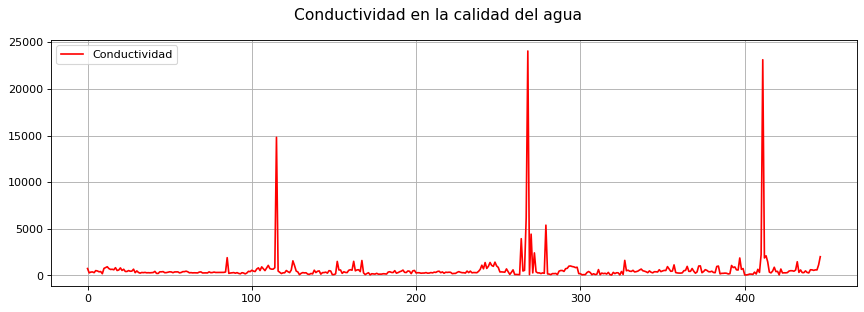

In [26]:
##Grafica de parametros Materia Fecal

fig, ax2 = plt.subplots(num=None, figsize=(13, 4), dpi=80, facecolor='w', edgecolor='k')
fig.suptitle('Materia Fecal en la calidad del Agua', fontsize=14)
ax2.plot(range(0, tam), FC_parametro, color='orange', label='Materia Fecal')
legend = ax2.legend()
plt.grid()

fig, ax2 = plt.subplots(num=None, figsize=(13, 4), dpi=80, facecolor='w', edgecolor='k')
ax2.plot(range(0, tam), COND_parametro, color='red', label='Conductividad')
fig.suptitle('Conductividad en la calidad del agua ', fontsize=14)
legend = ax2.legend()
plt.grid()

plt.show()

podemos ver que ambos parametros semantienen mayormente estavle con algunos pocos picos extremos cada uno

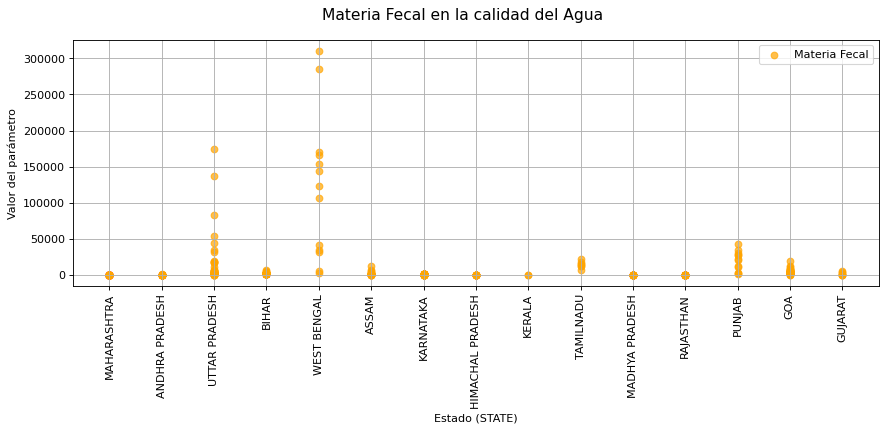

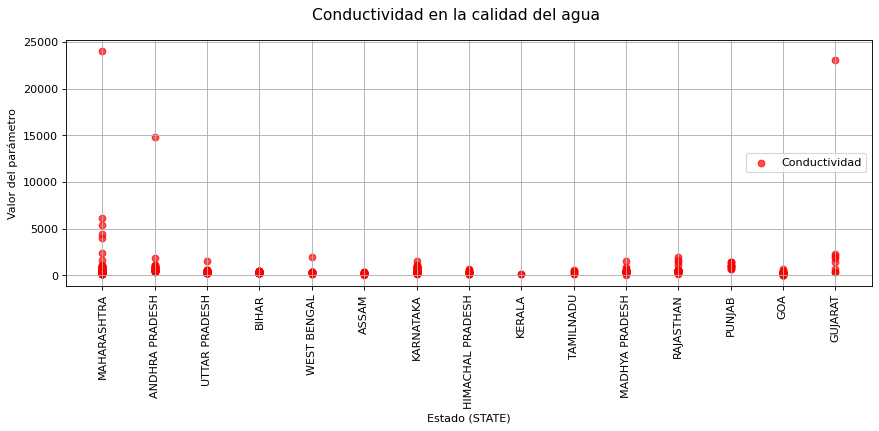

In [27]:
# Gráfica de Materia Fecal
fig, ax2 = plt.subplots(figsize=(13, 4), dpi=80)
fig.suptitle('Materia Fecal en la calidad del Agua', fontsize=14)

ax2.scatter(STATE_N, FC_parametro, color='orange', label='Materia Fecal', alpha=0.7)

ax2.set_xlabel('Estado (STATE)')
ax2.set_ylabel('Valor del parámetro')
ax2.legend()
plt.xticks(rotation=90)
plt.grid(True)


# Gráfica de Conductividad
fig, ax2 = plt.subplots(figsize=(13, 4), dpi=80)
fig.suptitle('Conductividad en la calidad del agua', fontsize=14)

ax2.scatter(STATE_N, COND_parametro, color='red', label='Conductividad', alpha=0.7)

ax2.set_xlabel('Estado (STATE)')
ax2.set_ylabel('Valor del parámetro')
ax2.legend()
plt.xticks(rotation=90)
plt.grid(True)

plt.show()


podemos ver que hay dos estados en los que los que hay una alta cantidad de Materia Fecal causando valores altos de FC, se puede obesevar que UTTAR PRADESH es un estado recurrente en los que los parametros actuan de  forma anormal durante las graficas pasadas:

# **Ingeniería de Características**


**Water Quality Index:** El Índice de la Calidad del Agua se calcula agregando  linealmente el índice de calidad por la masa

WQI = sum(**qr**n * **W**n)

**qr**n: Rango de Calidad para el n parámetro de calidad de agua.

**W**n: Unidad de peso para el n parámetro.

A continuación se calcula un método estándar **[2]** para calcular el rango de calidad **qr** para cada parámetro.

* Rango de calidad para **pH**. Se crea una nueva columna con los rangos **pH** de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **pH = [7.0 ; 8.5]**
    + 80:  *agua moderada*     **pH = [6.8 ; 6.9) o (8.5 ; 8.6)**
    + 60:  *agua dura* **pH = [6.7 ; 6.8) o [8.6 ; 8.8)**
    + 40:  *agua muy dura* **pH = [6.5 ; 6.7) o [8.8 ; 9.0)**
    + 0:   rango agua residuales

In [28]:
#Función definida por el usuario para definir el rango de calidad de agua según el pH
# Se crea una nueva columna para los rangos del parametro

df02 = df01.withColumn("qrPH", F.when(((df01.pH>= 7.0) & (df01.pH <= 8.5)), 100)
                               .when(((df01.pH>= 6.8) & (df01.pH < 6.9)) | ((df01.pH> 8.5) & (df01.pH < 8.6)), 80)
                               .when(((df01.pH>= 6.7) & (df01.pH < 6.8)) | ((df01.pH>= 8.6) & (df01.pH < 8.8)), 60)
                               .when(((df01.pH>= 6.) & (df01.pH < 6.7)) | ((df01.pH>= 8.8) & (df01.pH < 9.0)), 40)
                               .otherwise(0))






* Rango de calidad para **Oxigeno Disuelto**. Se crea una nueva columna con los rangos DO de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **DO>=6.0**
    + 80:  *agua moderada* **DO = [5.1, 6.0)**
    + 60:  *agua dura* **DO = [4.1, 5.0]**
    + 40:  *agua muy dura* **DO = [3.0, 4.0]**
    + 0:   rango agua residuales

In [29]:
#Función definida por el usuario para definir el rango de calidad de agua según el DO
# Se crea una nueva columna para los rangos del parametro

df02 = df02.withColumn("qrDO", F.when(((df02.DO>= 6.0)), 100)
                               .when(((df02.DO>= 5.1) & (df02.DO < 6.0)),80)
                               .when(((df02.DO>= 4.1) & (df02.DO <= 5.0)),60)
                               .when(((df02.DO>= 3.0) & (df02.DO <= 4.0)),40)
                               .otherwise(0))



* Rango de calidad para **Conductividad**. Se crea una nueva columna con los rangos CONDUCTIVITY de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **CONDUCTIVITY = [0.0,75.0]**
    + 80:  *agua moderada* **CONDUCTIVITY = (75.0, 150.0]**
    + 60:  *agua dura* **CONDUCTIVITY = (150.0, 225.0]**
    + 40:  *agua muy dura* **CONDUCTIVITY = (225.0, 300.0]**
    + 0:   rango agua residuales

In [30]:
#Función definida por el usuario para definir el rango de calidad de agua según el Conductivity
# Se crea una nueva columna para los rangos del parametro

df02 = df02.withColumn("qrCOND", F.when(((df02.CONDUCTIVITY>= 0.0) & (df02.CONDUCTIVITY <= 75.0)), 100)
                               .when(((df02.CONDUCTIVITY>75.0) & (df02.CONDUCTIVITY <= 150.0)),80)
                               .when(((df02.CONDUCTIVITY>150.0) & (df02.CONDUCTIVITY <= 225.0)),60)
                               .when(((df02.CONDUCTIVITY>225.0) & (df02.CONDUCTIVITY <= 300.0)),40)
                               .otherwise(0))



* Rango de calidad para **Demanda Bioquímica de Oxigeno**. Se crea una nueva columna con los rangos **BOD** de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **BOD = [0.0,3.0)**
    + 80:  *agua moderada* **BOD = [3.0, 6.0)**
    + 60:  *agua dura* **BOD = [6.0, 80.0)**
    + 40:  *agua muy dura* **BOD = [80.0, 125.0]**
    + 0:   rango agua residuales

In [31]:
#Función definida por el usuario para definir el rango de calidad de agua según el BOD
# Se crea una nueva columna para los rangos del parametro

df02 = df02.withColumn("qrBOD", F.when(((df02.BOD>= 0.0) & (df02.BOD < 3.0)), 100)
                               .when(((df02.BOD>=3.0) & (df02.BOD < 6.0)),80)
                               .when(((df02.BOD>=6.0) & (df02.BOD < 80.0)),60)
                               .when(((df02.BOD>=80.0) & (df02.BOD <= 125.0)),40)
                               .otherwise(0))



* Rango de calidad para **Nitratos**. Se crea una nueva columna con los rangos **NITRATE_N_NITRITE_N** de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **NITRATE_N_NITRITE_N = [0.0,20.0)**
    + 80:  *agua moderada* **NITRATE_N_NITRITE_N =  [20.0, 50.0)**
    + 60:  *agua dura* **NITRATE_N_NITRITE_N = [50.0, 100.0)**
    + 40:  *agua muy dura* **NITRATE_N_NITRITE_N = [100.0, 200.0]**
    + 0:   rango agua residuales

In [32]:
#Función definida por el usuario para definir el rango de calidad de agua según el NITRATO
# Se crea una nueva columna para los rangos del parametro

df02 = df02.withColumn("qrNN", F.when(((df02.NITRATE_N_NITRITE_N>= 0.0) & (df02.NITRATE_N_NITRITE_N < 20.0)), 100)
                               .when(((df02.NITRATE_N_NITRITE_N>=20.0) & (df02.NITRATE_N_NITRITE_N < 50.0)),80)
                               .when(((df02.NITRATE_N_NITRITE_N>=50.0) & (df02.NITRATE_N_NITRITE_N < 100.0)),60)
                               .when(((df02.NITRATE_N_NITRITE_N>=100.0) & (df02.NITRATE_N_NITRITE_N <= 200.0)),40)
                               .otherwise(0))



* Rango de calidad para **Coliforme Fecal**. Se crea una nueva columna con los rangos FECAL_COLIFORM de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **FECAL_COLIFORM = [0.0,5.0)**
    + 80:  *agua moderada* **FECAL_COLIFORM = [5.0, 50.0)**
    + 60:  *agua dura* **FECAL_COLIFORM = [50.0, 500.0)**
    + 40:  *agua muy dura* **FECAL_COLIFORM = [500.0, 10000.0]**
    + 0:   rango agua residuales

In [33]:
#Función definida por el usuario para definir el rango de calidad de agua según el Materia Fecal
# Se crea una nueva columna para los rangos del parametro

df02 = df02.withColumn("qrFC", F.when(((df02.FECAL_COLIFORM>= 0.0) & (df02.FECAL_COLIFORM < 5.0)), 100)
                               .when(((df02.FECAL_COLIFORM>=5.0) & (df02.FECAL_COLIFORM < 50.0)),80)
                               .when(((df02.FECAL_COLIFORM>=50.0) & (df02.FECAL_COLIFORM < 500.0)),60)
                               .when(((df02.FECAL_COLIFORM>=500.0) & (df02.FECAL_COLIFORM <= 10000.0)),40)
                               .otherwise(0))


Inspeccion Visual

In [34]:
df02.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+----+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFC|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+----+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|   80| 100| 100|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|   80| 100|  60|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|       355.0| 4.2|                9.0|          59.0| 100|  80|     0|   80| 100|  60|
|        2179|GODAVARI RIVER AT...|MAHARASHTRA|24.8|5.5|7.8|       371.0| 5.6|               3.55|          90.0| 100|

A continuación se cálcula el WQI para cada parámetro.

La masa del agua puede ser calculado por el producto de su volumen por su densidad. La densidad del agua es aproximadamente 1 gramo por centimetro cúbico (g/cm^3)

In [35]:
df03 = df02.withColumn("wph", df02.qrPH * 0.165)
df03 = df03.withColumn("wDO", df02.qrDO * 0.281)
df03 = df03.withColumn("wCOND", df02.qrCOND * 0.0234)
df03 = df03.withColumn("wBOD", df02.qrBOD * 0.009)
df03 = df03.withColumn("wNN", df02.qrNN * 0.028)
df03 = df03.withColumn("wFC", df02.qrFC * 0.281)

In [36]:
df03.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+----+----+------------------+------------------+------------------+------------------+------------------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFC| wph|               wDO|             wCOND|              wBOD|               wNN|               wFC|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+----+----+------------------+------------------+------------------+------------------+------------------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|   80| 100| 100|16.5|              28.1|               0.0|              0.72|2.8000000000000003|              28.1|
|        217

Finalmente se calcula el **Índice de Calidad del Agua**

In [37]:
#se crea la columna WQI <Nota: Son muy pocos Parametros para un estudio Serio de la calidad del agua>
df04 = df03.withColumn("WQI", df03.wph + df03.wDO + df03.wCOND + df03.wBOD + df03.wNN + df03.wFC)
df04.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+----+----+------------------+------------------+------------------+------------------+------------------+-----------------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFC| wph|               wDO|             wCOND|              wBOD|               wNN|               wFC|              WQI|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+----+----+------------------+------------------+------------------+------------------+------------------+-----------------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|   80| 100| 100|16.5|              28.1|               0.0|              0.

In [38]:
#  redondear a 3 decimales

from pyspark.sql.functions import round

df04 = df04.withColumn("WQI", round(df04["WQI"], 3))
df04 = df04.withColumn("wph", round(df04["wph"], 3))
df04 = df04.withColumn("wDO", round(df04["wDO"], 3))
df04 = df04.withColumn("wCOND", round(df04["wCOND"], 3))
df04 = df04.withColumn("wBOD", round(df04["wBOD"], 3))
df04 = df04.withColumn("wNN", round(df04["wNN"], 3))
df04 = df04.withColumn("wFC", round(df04["wFC"], 3))

df04.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+----+----+-----+-----+----+---+-----+------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFC| wph|  wDO|wCOND|wBOD|wNN|  wFC|   WQI|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+----+----+-----+-----+----+---+-----+------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|   80| 100| 100|16.5| 28.1|  0.0|0.72|2.8| 28.1| 76.22|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|   80| 100|  60|16.5| 28.1|0.936|0.72|2.8|16.86|65.916|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|       355

* A continuación se clasifica el agua sobre la base de su índice de calidad **[2]**

* Clasificación de calidad del agua:

    + Excelente: *agua dulce* **WQI = [0.0,25.0]**
    + Buena:  *agua moderada* **WQI = [26.0, 50.0]**
    + Baja:  *agua dura* **WQI = [51.0, 75.0]**
    + Muy_Baja:  *agua muy dura* **WQI = [76.0, 100.0]**
    + Inadecuada:   rango agua residuales

In [39]:
df05 = df04.withColumn("CALIDAD", F.when(((df04.WQI>= 0.0) & (df04.WQI <= 25.0)), "Excelente")
                               .when(((df04.WQI> 25.0) & (df04.WQI <= 50.0)),"Buena")
                               .when(((df04.WQI> 50.0) & (df04.WQI <= 75.0)),"Baja")
                               .when(((df04.WQI> 75.0) & (df04.WQI <= 100.0)),"Muy_Baja")
                               .otherwise("Inadecuada"))

df05.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+----+----+-----+-----+----+---+-----+------+--------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFC| wph|  wDO|wCOND|wBOD|wNN|  wFC|   WQI| CALIDAD|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+----+----+-----+-----+----+---+-----+------+--------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|   80| 100| 100|16.5| 28.1|  0.0|0.72|2.8| 28.1| 76.22|Muy_Baja|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|   80| 100|  60|16.5| 28.1|0.936|0.72|2.8|16.86|65.916|    Baja|
|        2182|GODAVARI RI

In [108]:
#Conteo de ocurrencias de CALIDAD

df05.groupBy("CALIDAD").count().show()

+---------+-----+
|  CALIDAD|count|
+---------+-----+
|Excelente|   10|
|    Buena|   75|
| Muy_Baja|   34|
|     Baja|  328|
+---------+-----+



Podemos ver que en la mayoria de Casos la Calidad del agua es baja con 328 en baja, y llega a ser exelente en tan solo 10 casos.

In [118]:
# Conteo de Calidad Por estado
df05.groupBy("STATE", "CALIDAD").count().show()

+----------------+---------+-----+
|           STATE|  CALIDAD|count|
+----------------+---------+-----+
|       RAJASTHAN| Muy_Baja|    4|
|       RAJASTHAN|     Baja|   23|
|  ANDHRA PRADESH| Muy_Baja|    9|
|     MAHARASHTRA| Muy_Baja|   12|
|   UTTAR PRADESH|     Baja|   32|
|           BIHAR|     Baja|   53|
|  ANDHRA PRADESH|Excelente|    1|
|       KARNATAKA|     Baja|   44|
|          PUNJAB|    Buena|    7|
|           BIHAR|Excelente|    1|
|  ANDHRA PRADESH|     Baja|   20|
|     WEST BENGAL|    Buena|   11|
|       KARNATAKA|    Buena|    3|
|          KERALA|     Baja|    2|
|HIMACHAL PRADESH|     Baja|   15|
|           BIHAR|    Buena|    6|
|          PUNJAB|Excelente|    2|
|HIMACHAL PRADESH| Muy_Baja|    1|
|   UTTAR PRADESH|Excelente|    2|
|           ASSAM|    Buena|    3|
+----------------+---------+-----+
only showing top 20 rows



In [119]:
#Promedio de Calidadpor estado
df05.groupBy("STATE").mean("WQI").show()

+----------------+------------------+
|           STATE|          avg(WQI)|
+----------------+------------------+
|     WEST BENGAL| 50.28676923076924|
|             GOA| 49.42133333333332|
|       RAJASTHAN|            64.636|
|HIMACHAL PRADESH|          69.25075|
|         GUJARAT| 61.21000000000001|
|           BIHAR| 57.49460000000002|
|       KARNATAKA| 60.08399999999999|
|   UTTAR PRADESH|  53.9987234042553|
|  MADHYA PRADESH| 70.20909090909089|
|     MAHARASHTRA|63.323777777777835|
|          PUNJAB| 38.57333333333333|
|       TAMILNADU| 49.77142857142858|
|  ANDHRA PRADESH| 64.97988235294119|
|          KERALA|            67.032|
|           ASSAM|57.115818181818184|
+----------------+------------------+



#**Visualización de los datos por Estados de la INDIA**

* Se visualizan los datos obtenidos de CALIDAD en cada región/estado de la INDIA

In [40]:
#Primero se obtienen los nombres de regiones sobre el Dataframe de Calidad
df05.select('STATE').distinct().collect()

[Row(STATE='WEST BENGAL'),
 Row(STATE='GOA'),
 Row(STATE='RAJASTHAN'),
 Row(STATE='HIMACHAL PRADESH'),
 Row(STATE='GUJARAT'),
 Row(STATE='BIHAR'),
 Row(STATE='KARNATAKA'),
 Row(STATE='UTTAR PRADESH'),
 Row(STATE='MADHYA PRADESH'),
 Row(STATE='MAHARASHTRA'),
 Row(STATE='PUNJAB'),
 Row(STATE='TAMILNADU'),
 Row(STATE='ANDHRA PRADESH'),
 Row(STATE='KERALA'),
 Row(STATE='ASSAM')]

* Se observan los nombres en el GPD, para hacer que sean similares frente a los del dataframe

In [41]:
#Se visualiza el dataframe geográfico pandas (gpd )
type(gpdf00)



geopandas.geodataframe.GeoDataFrame

In [42]:
gpdf00.columns

Index(['st_nm', 'geometry'], dtype='object')

<Axes: >

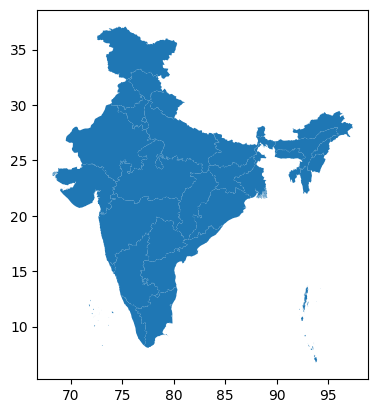

In [43]:
gpdf00.plot()

In [44]:
#Nombres de los estados en GeoPandas
gpdf00['st_nm'].unique()

array(['Andaman & Nicobar Island', 'Arunanchal Pradesh', 'Assam', 'Bihar',
       'Chandigarh', 'Chhattisgarh', 'Dadara & Nagar Havelli',
       'Daman & Diu', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu & Kashmir', 'Jharkhand', 'Karnataka', 'Kerala',
       'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
       'Meghalaya', 'Mizoram', 'Nagaland', 'NCT of Delhi', 'Puducherry',
       'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
       'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal', 'Odisha',
       'Andhra Pradesh'], dtype=object)

In [45]:
#Se ajustan los nombres de GPD, eliminando caracteres
gpdf01 = gpdf00.replace({'Andaman & Nicobar Island' : 'Andaman And Nicobar Island',
                         'Dadara & Nagar Havelli' : 'Dadara And Nagar Havelli',
                         'Daman & Diu' : 'Daman And Diu',
                         'Jammu & Kashmir' : 'Jammu And Kashmir',
                         'NTC of Delhi' : 'Delhi',
                         'Telangana' : 'Telengana'
                         })

gpdf01['st_nm'].unique()

array(['Andaman And Nicobar Island', 'Arunanchal Pradesh', 'Assam',
       'Bihar', 'Chandigarh', 'Chhattisgarh', 'Dadara And Nagar Havelli',
       'Daman And Diu', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu And Kashmir', 'Jharkhand', 'Karnataka', 'Kerala',
       'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
       'Meghalaya', 'Mizoram', 'Nagaland', 'NCT of Delhi', 'Puducherry',
       'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telengana',
       'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal', 'Odisha',
       'Andhra Pradesh'], dtype=object)

Se hacen cambios sobre el dataframe spark para coincidir nombres

* Para efectos de pintar el mapa se pasa el spark dataframe a pandas
* El nombre de TAMILNADU se cambia por TAMIL NADU
* Se deja sólo la letra inicial mayúsula sobre Dataframe

In [46]:
#Se cambia a objeto pandas
pandasDF = df05.toPandas()

#Cambio TAMILNADU a TAMIL NADU
pandasDF['STATE'].replace({'TAMILNADU' : 'TAMIL NADU'}, inplace= True)

#Se deja letra inicial mayúscula en columna 'STATE'
pandasDF['STATE'] = pandasDF['STATE'].str.title()


#Se comprueba el cambio
pandasDF['STATE'].head()

,STATE
0,Maharashtra
1,Maharashtra
2,Maharashtra
3,Maharashtra
4,Maharashtra


In [47]:
#Se cambia el nombre en el gpd a STATES
gpdf02 = gpdf01.rename(columns={'st_nm': 'STATE'})
#Se combinan los  dataframes (gpdf02, pandasDF) inner: union de claves 'STATE' de ambos dataframes
dfMap = pd.merge(gpdf02, pandasDF, on='STATE', how='inner')
INDIAmap = pd.merge(gpdf02, pandasDF, on='STATE', how='outer')

#Se toman puntos a bajo coste que garantizan estar dentro de la geometria (mapa): columna nueva coordenas
dfMap['coords'] = dfMap['geometry'].apply(lambda x: x.representative_point().coords[:])
dfMap['coords'] = [coords[0] for coords in dfMap['coords']]

#Se eliminan los datos duplicados
dfMap = dfMap.drop_duplicates(subset=['STATE'])

dfMap.head()

,STATE,geometry,STATION CODE,LOCATIONS,TEMP,DO,pH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,...,qrFC,wph,wDO,wCOND,wBOD,wNN,wFC,WQI,CALIDAD,coords
0,Assam,"MULTIPOLYGON (((89.74323 26.30362, 89.7429 26....",1260,BRAHAMPUTRA AT KHERGHAT (AFTER CONFL. WITH DIB...,22.299999,7.2,7.1,216.0,1.500000,1.4,...,60,16.5,28.10,1.404,0.90,2.8,16.86,66.564,Baja,"(90.76265036100918, 26.052225148671738)"
22,Bihar,"MULTIPOLYGON (((84.5072 24.26323, 84.50355 24....",1074,"GANGA AT BUXAR,BIHAR",24.500000,8.4,8.1,371.0,2.500000,0.0,...,40,16.5,28.10,0.000,0.90,2.8,11.24,59.540,Baja,"(86.12533485112044, 25.902658098342613)"
82,Goa,"MULTIPOLYGON (((74.11918 14.75344, 74.1135 14....",1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,29.799999,5.7,7.2,189.0,2.000000,0.2,...,40,16.5,22.48,1.404,0.90,2.8,11.24,55.324,Baja,"(74.10419744395932, 15.347738516669267)"
118,Gujarat,"MULTIPOLYGON (((71.70375 20.99958, 71.70375 20...",1343,AHMEDABAD,27.600000,6.5,8.6,649.0,21.799999,4.0,...,40,9.9,28.10,0.000,0.54,2.8,11.24,52.580,Baja,"(71.98745611099406, 22.414733888807973)"
126,Himachal Pradesh,"POLYGON ((76.79634 33.2549, 76.80351 33.25275,...",1553,"YAMUNA , U/S PAONTA SAHIB, H.P",22.299999,7.7,7.5,465.0,1.200000,0.2,...,80,16.5,28.10,0.000,0.90,2.8,22.48,70.780,Baja,"(77.35024360355877, 31.817465026989453)"


In [48]:
#Cambios finales para ver que no hayan espacios inesperados
pandasDF['STATE'] = pandasDF['STATE'].str.strip()
gpdf01['STATE'] = gpdf02['STATE'].str.title().str.strip()

In [49]:
print("Estados en pandasDF:")
print(sorted(pandasDF['STATE'].unique()))

print("\nEstados en gpdf02:")
print(sorted(gpdf01['STATE'].unique()))


Estados en pandasDF:
['Andhra Pradesh', 'Assam', 'Bihar', 'Goa', 'Gujarat', 'Himachal Pradesh', 'Karnataka', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Punjab', 'Rajasthan', 'Tamil Nadu', 'Uttar Pradesh', 'West Bengal']

Estados en gpdf02:
['Andaman And Nicobar Island', 'Andhra Pradesh', 'Arunanchal Pradesh', 'Assam', 'Bihar', 'Chandigarh', 'Chhattisgarh', 'Dadara And Nagar Havelli', 'Daman And Diu', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh', 'Jammu And Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Nct Of Delhi', 'Odisha', 'Puducherry', 'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telengana', 'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal']


* Se procede a pintar con SEABORN

In [50]:
## para pintar se installa map Classify
!pip install mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.2 MB/s eta 0:00:00


<Axes: >

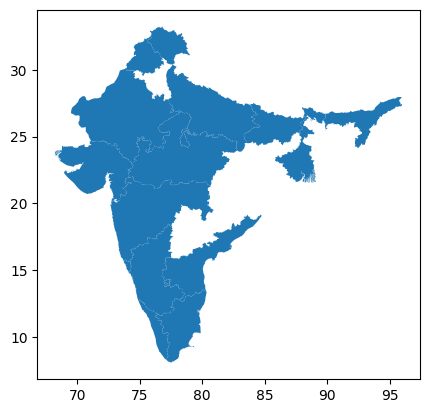

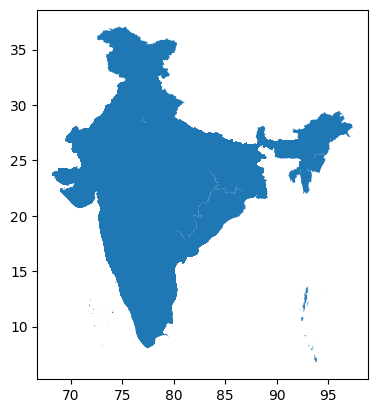

In [51]:
dfMap.plot(missing_kwds={'color': 'lightgrey'})
INDIAmap.plot(missing_kwds={'color': 'lightgrey'})

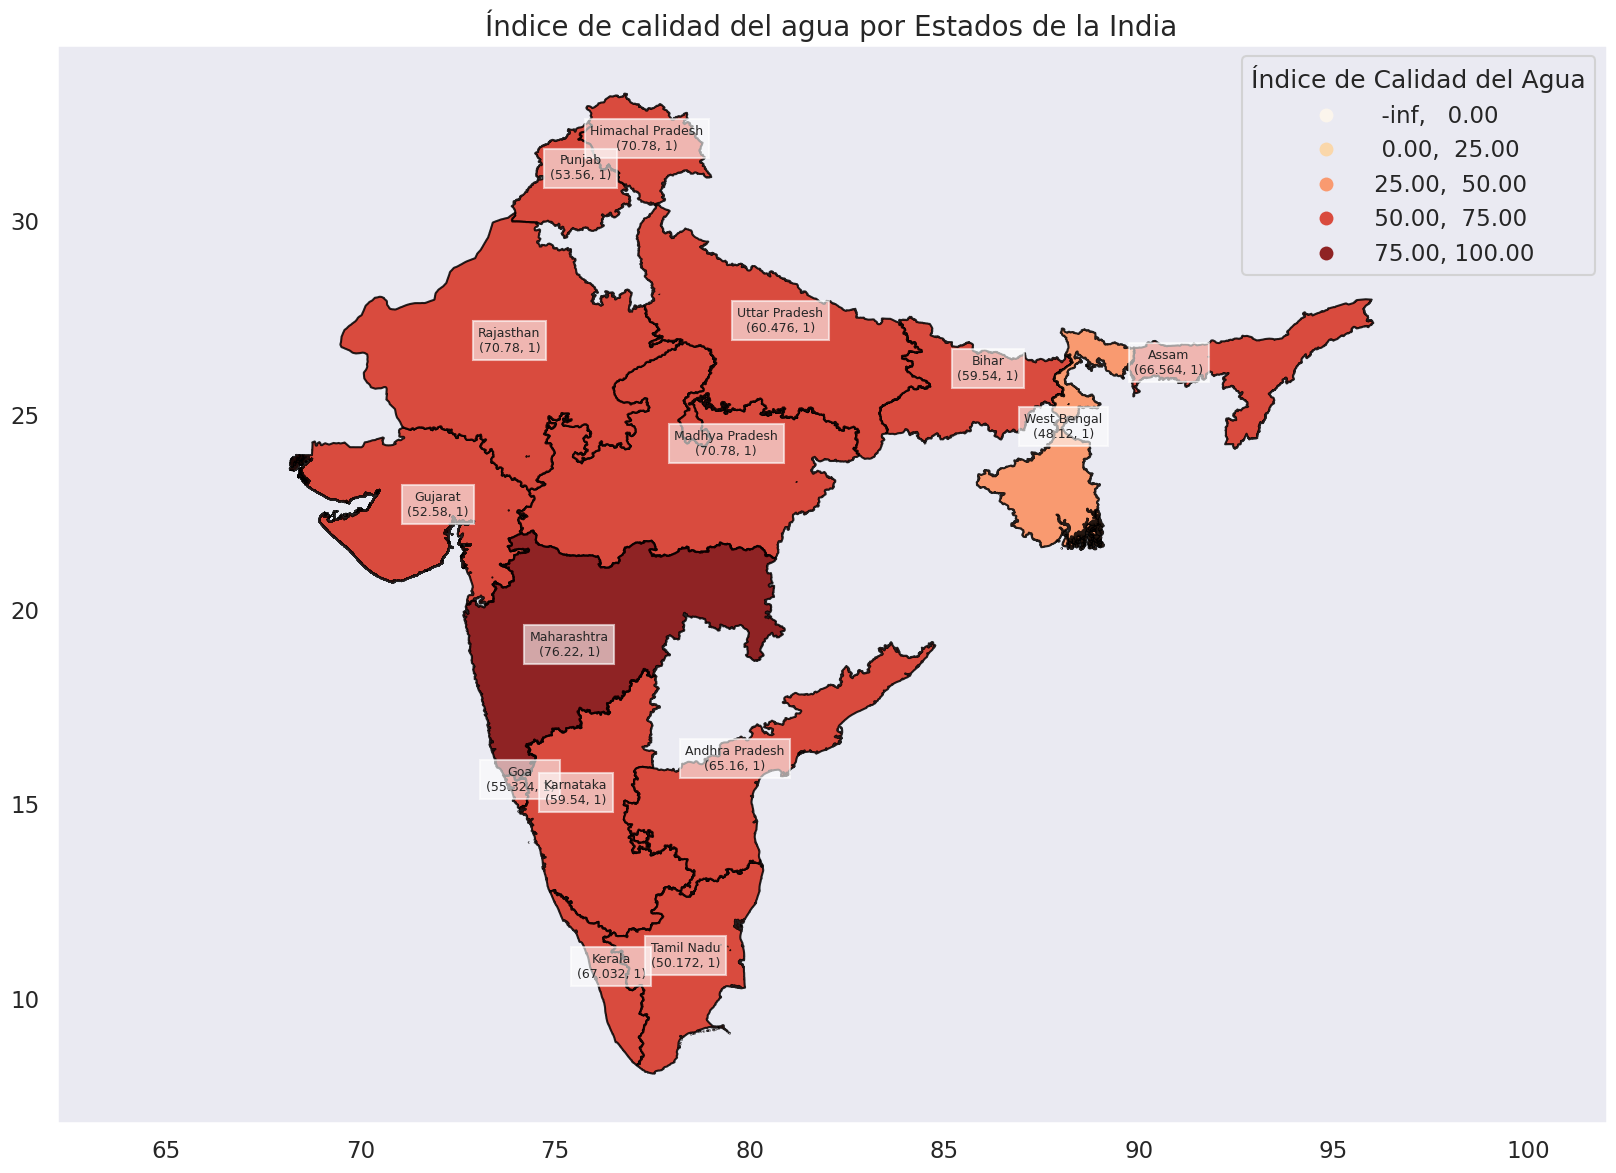

In [122]:
#Grafica de WQI por estado para visualizar en un mapa sin mostrar Estados en los que no hay datos
sns.set_context('talk')
sns.set_style('dark')
cmap = 'OrRd'
sizeFig = (20, 14)

# Graficar el mapa
ax = dfMap.plot(
    column='WQI',
    cmap=cmap,
    figsize=sizeFig,
    scheme='User_Defined',
    classification_kwds=dict(bins=[0, 25, 50, 75, 100]),
    edgecolor='black',
    legend=True,
    alpha=0.85
)

# Bucle para mostrar el nombre del estado y el WQI
for idx, fila in dfMap.iterrows():
    ax.text(
        fila.coords[0],
        fila.coords[1],
        s=f"{fila['STATE']}\n{(fila['WQI'], 1)}",
        size=9,
        horizontalalignment='center',
        bbox={'facecolor': 'white', 'alpha': 0.6, 'pad': 4}
    )

# Títulos y leyendas
ax.get_legend().set_title('Índice de Calidad del Agua')
ax.set_title('Índice de calidad del agua por Estados de la India', fontsize=20)
plt.axis('equal')
plt.show()

* Se requiere hacer una gráfica de WQI para cada STATE

In [53]:
##Se convierte el DFpandas a Dataframe spark
sparkDF00 = spark.createDataFrame(pandasDF)

#### Se crea una Tabla de Vista Temporal para hacer consultas SQL
sparkDF00.createOrReplaceTempView("df10_sql")

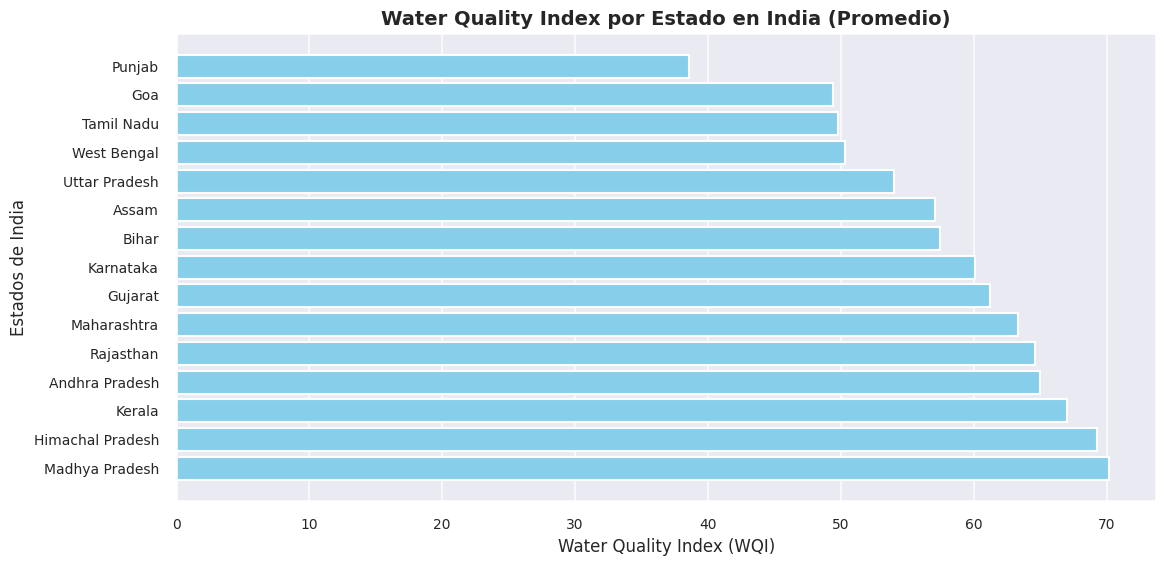

In [144]:
# Agrupar por estado y calcular el promedio del  para que no se calculen los estados repetidos y se creen varias Barras por estado
promediosDF = sparkDF00.groupBy("STATE").agg(avg("WQI").alias("WQI_avg"))

# Se Ordenan
promediosDF = promediosDF.orderBy("WQI_avg", ascending=False)

# Se crean listas por medio de rdd
Estados = promediosDF.select("STATE").rdd.map(lambda fila: fila.STATE).collect()
val_WQI = promediosDF.select("WQI_avg").rdd.map(lambda fila: fila.WQI_avg).collect()


plt.figure(figsize=(12, 6))
plt.barh(Estados, val_WQI, color='skyblue')
plt.xlabel('Water Quality Index (WQI)', fontsize=12)
plt.ylabel('Estados de India', fontsize=12)
plt.title('Water Quality Index por Estado en India (Promedio)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', alpha=0.7)
plt.tight_layout()
plt.show()

En los estados de Madhya Pradesh, Himachal Pradesh, Kerala y Andhra Pradesh se logran observar los promedios más altos, lo que podría indicar problemas de calidad del agua en esas regiones.

En cambio, Punjab, Goa, Tamil Nadu y West Bengal muestran los promedios más bajos, lo que sugiere una mejor calidad del agua en estos estados.

podemos ver que ningun estado se acerca a tener un promedio cercano a 25 o menor, con  lo que se concideraria agua dulce, todos estan por encima por lo que podemos observar que en Promedio El agua no es de Buena Calidad, apesar de que haya varios estados en el rango de agua moredada es decir de 25 hasta 50 WQI. [2]

#**Creación de Modelo: Regresión Lineal**

* Se requiere predecir el valor WQI
* Se crea un vector ensamblador con las columnas **"Rangos de Calidad (qr)"**
* Se normalizan las columnas a través de Normalizer
* Se importa LinearRegression y se aplica los datos con el vector normalizado
* Se hace un "pipeline" para incluir el modelo
* Se separa los datos aleatoriamente (80%:entrenamiento, 20%:prueba)
* Se entrena el modelo con los datos de entrenamiento
* Se obtienen las predicciones con los datos de prueba y se muestran
* Se revisa el rendimiento del modelo con la métrica r2

In [55]:
sparkDF00.columns

['STATION CODE',
 'LOCATIONS',
 'STATE',
 'TEMP',
 'DO',
 'pH',
 'CONDUCTIVITY',
 'BOD',
 'NITRATE_N_NITRITE_N',
 'FECAL_COLIFORM',
 'qrPH',
 'qrDO',
 'qrCOND',
 'qrBOD',
 'qrNN',
 'qrFC',
 'wph',
 'wDO',
 'wCOND',
 'wBOD',
 'wNN',
 'wFC',
 'WQI',
 'CALIDAD']

In [56]:
#Se normalizan en un vector
from pyspark.ml.feature import VectorAssembler, Normalizer
vectorQR = VectorAssembler(inputCols=['qrPH', 'qrDO', 'qrCOND', 'qrBOD', 'qrNN', 'qrFC'], outputCol='features')
normalizarQR = Normalizer(inputCol='features', outputCol='features_normalizada', p=1.0)

In [57]:
# Se importa y configura el modelo de Regresión Lineal
from pyspark.ml.regression import LinearRegression
modelo_A_Lineal = LinearRegression(
    featuresCol='features_normalizada',
    labelCol='WQI',        # Variable que se quiere predecir
    maxIter=10,            # Máximo número de iteraciones
    regParam=0.3,          # Parámetro de regularización (para evitar sobreajuste)
    elasticNetParam=0.2    # Mezcla entre L1 y L2 regularización
)

In [58]:
#Se crea el pipeline: presentar las etapas de ingesta del emtrenamiento final del modelo
from pyspark.ml import Pipeline
pipe_A = Pipeline(stages=[vectorQR, normalizarQR, modelo_A_Lineal])

In [59]:
#Separación de datos aleatoriamente: 20% para prueba
train_data, test_data = sparkDF00.randomSplit([0.8, 0.2])

In [60]:
sparkDF00.dtypes

[('STATION CODE', 'bigint'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'double'),
 ('DO', 'double'),
 ('pH', 'double'),
 ('CONDUCTIVITY', 'double'),
 ('BOD', 'double'),
 ('NITRATE_N_NITRITE_N', 'double'),
 ('FECAL_COLIFORM', 'double'),
 ('qrPH', 'bigint'),
 ('qrDO', 'bigint'),
 ('qrCOND', 'bigint'),
 ('qrBOD', 'bigint'),
 ('qrNN', 'bigint'),
 ('qrFC', 'bigint'),
 ('wph', 'double'),
 ('wDO', 'double'),
 ('wCOND', 'double'),
 ('wBOD', 'double'),
 ('wNN', 'double'),
 ('wFC', 'double'),
 ('WQI', 'double'),
 ('CALIDAD', 'string')]

In [61]:
#Se crea el modelo LR para entrenamiento
LR_Modelo = pipe_A.fit(train_data)

Se muestran las primeras 20 predicciones comparadas con el valor real


In [62]:
#Se hacen las predicciones con los datos de entrenamiento
pred_Model_A = LR_Modelo.transform(train_data)
pred_Model_A = pred_Model_A.withColumn('prediction', round(pred_Model_A['prediction'], 3))
pred_Model_A.select('WQI', 'prediction').show(20)

+------+----------+
|   WQI|prediction|
+------+----------+
| 76.22|    73.148|
|  20.2|    11.113|
|65.916|     64.56|
|66.096|    64.445|
| 59.54|    59.918|
|60.476|    60.199|
|60.476|    60.199|
| 48.12|    48.621|
| 48.12|    48.621|
| 48.12|    48.621|
| 48.12|    48.621|
| 48.12|    48.621|
| 59.36|    59.834|
| 59.36|    59.834|
|60.296|    60.134|
| 59.36|    59.834|
| 48.12|    48.621|
| 59.54|    59.918|
| 59.54|    59.918|
| 48.12|    48.621|
+------+----------+
only showing top 20 rows



In [63]:
#Rendimiento del modelo con r2 como métrica
metricaR2 = LR_Modelo.stages[2].summary.r2
metricaR2 = metricaR2 * 100
print("El valor de R2 es: %f" %metricaR2)


El valor de R2 es: 93.718040


Un valor cercano a 100% del R2 significa que el modelo explica bien la variabilidad.

In [64]:
# Se hacen las predicciones con los datos de prueba
predicciones_test = LR_Modelo.transform(test_data)

# Se redondean las predicciones para facilidad de lectura
predicciones_test = predicciones_test.withColumn('prediction', round(predicciones_test['prediction'], 3))

# Se muestran algunas predicciones vs. valores reales
predicciones_test.select('WQI', 'prediction').show(20)


+------+----------+
|   WQI|prediction|
+------+----------+
|  76.4|     72.69|
|60.476|    60.199|
|60.476|    60.199|
| 59.54|    59.918|
| 64.98|    64.675|
| 70.78|    68.788|
|50.172|     51.61|
| 59.36|    59.834|
| 48.12|    48.621|
|60.944|    60.322|
| 65.16|    64.546|
| 19.84|     11.78|
| 48.12|    48.621|
| 70.78|    69.811|
|60.476|    60.199|
| 47.94|    50.624|
|60.944|    60.322|
| 64.98|    65.792|
| 76.22|    73.148|
| 59.36|    61.003|
+------+----------+
only showing top 20 rows



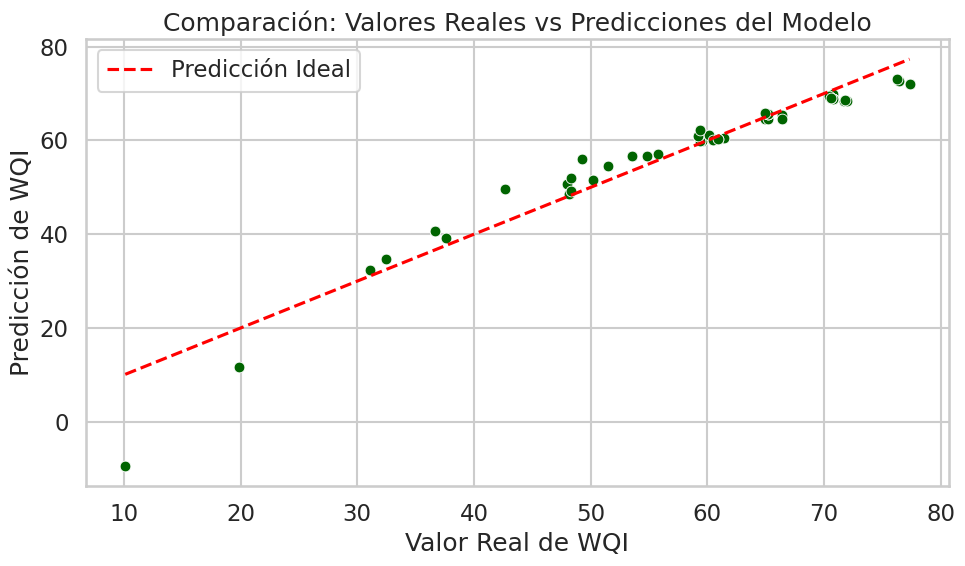

In [65]:
# Convertimos el DataFrame de PySpark a Pandas para graficar
pandas_preds = predicciones_test.select('WQI', 'prediction').toPandas()

# Gráfico de dispersión: real vs predicción
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.scatterplot(data=pandas_preds, x='WQI', y='prediction', color='darkgreen', s=60)

# Línea de referencia ideal (si predicción == real)
plt.plot([pandas_preds['WQI'].min(), pandas_preds['WQI'].max()],
         [pandas_preds['WQI'].min(), pandas_preds['WQI'].max()],
         'r--', label='Predicción Ideal',color='red')

plt.xlabel('Valor Real de WQI')
plt.ylabel('Predicción de WQI')
plt.title('Comparación: Valores Reales vs Predicciones del Modelo')
plt.legend()
plt.tight_layout()

plt.show()

Se puede observar que el modelo entrenado por regresion Lineal se ajusta y logra predecir con un grado de acierto bastante alto, con un valor de R2 de 93 que se acerca al 100%, con valores que tambien son, en su mayoria, cercanos a la linea de ajuste

#**Creación de Modelo: Aprendizaje Profundo (Deep Learning)**

* Se requiere predecir el valor WQI
* Se crea un DF en pandas, se crea los vectores numpy de columnas **"Rangos de Calidad (qr)"** y **WQI**
* Se importa Scikit-Learn, para separar los datos (20% para prueba)
* Se importa Keras Sequential con layers Dense
* Se inicializa el modelo, y se añaden las capas, activador relu,  y ultima capa activacion linear
* Se compila el modelo con el optimizador Adam y la función de pérdida error cuadrático medio.
* Se realiza el entrenamiento

Este modelo es una red neuronal densa (fully connected) construida con Keras, que predice el valor del WQI (Índice de Calidad del Agua) a partir de 6 variables: qrPH, qrDO, qrCOND, qrBOD, qrNN, qrFC (que representan distintos parámetros químicos del agua).





> "En la actualidad, Keras es una de las API de redes neuronales más utilizadas para el desarrollo y las pruebas de redes neuronales. Facilita enormemente la creación de capas para las redes neuronales o la configuración de arquitecturas complejas" [8]

In [66]:
pandasDF.columns

Index(['STATION CODE', 'LOCATIONS', 'STATE', 'TEMP', 'DO', 'pH',
       'CONDUCTIVITY', 'BOD', 'NITRATE_N_NITRITE_N', 'FECAL_COLIFORM', 'qrPH',
       'qrDO', 'qrCOND', 'qrBOD', 'qrNN', 'qrFC', 'wph', 'wDO', 'wCOND',
       'wBOD', 'wNN', 'wFC', 'WQI', 'CALIDAD'],
      dtype='object')

**se hace uso de la biblioteca de scikit-learn para aplicar deep learning**

- lo anunciado solo corresponde a un atajo para aplicar los tensores, sin embargo perfectamente se puede solo hacer uso de MLiB Spark <Alto Volumen DE DATOS>

In [67]:
#Se obtienen en vector numpy datos de los rangos de calidad de los parámetros (qrParametros)
datos = pandasDF.iloc[:, 10:16].values

#Se obtienen en vector numpy datos de valor a predecir "WQI"
prede = pandasDF.iloc[:, 22:23].values

In [68]:
#Separación de datos con scikit-learn: train_test_split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(datos, prede, test_size=0.2, random_state=1) ## Se separan los datos en entrenamiento y prueba (80% - 20%)

In [69]:
print(" Cantidad de datos totales ", pandasDF.shape[0])
print(" Cantidad de datos de entrenamiento ", x_train.shape[0])
print(" Cantidad de datos de prueba ", x_test.shape[0])
print("")

 Cantidad de datos totales  447
 Cantidad de datos de entrenamiento  357
 Cantidad de datos de prueba  90



In [70]:
# Se importa Keras y sus componentes para crear un modelo de red neuronal
import keras
from keras.models import Sequential
from keras.layers import Dense

In [71]:
#Se ajustan las variables
epocas = 200
lotes = 31

# Se define el modelo de red neuronal con 3 capas ocultas (densas)
modelo_DL = Sequential()
modelo_DL.add(Dense(350, input_dim=6, activation='relu'))
modelo_DL.add(Dense(350, activation='relu'))
modelo_DL.add(Dense(350, activation='relu'))
modelo_DL.add(Dense(1, activation='linear')) ##Una sola neurona para la salida, ya que estamos prediciendo un solo valor numérico continuo (el WQI).

Aquí se crea una red neuronal secuencial, es decir, capa por capa en orden.

Dense significa una capa completamente conectada (fully connected).

350 es la cantidad de neuronas en esa capa.

input_dim=6 porque tienes 6 características (parámetros químicos).

activation='relu' le dice a la red cómo "activar" cada neurona. (la activacion relu es una activacion comunmente usada)

Se agregan 3 capas ocultas con 350 neuronas cada una.

In [72]:
## Se compila el modelo: Se compila el modelo con el optimizador Adam y la función de pérdida error cuadrático medio.
keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
modelo_DL.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

funcion de error (mean_squared_error mide qué tan lejos está la predicción del valor real).

optimizador usado: adam es un algoritmo eficiente que ajusta los pesos internos para mejorar las predicciones.

epochs=50: Se repite el proceso 50 veces sobre todo el conjunto de entrenamiento.

batch_size=32: Cada vez que aprende, usa 32 datos a la vez.

In [73]:
#Se presenta el resumen del modeloDL
modelo_DL.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 350)                 │           2,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 350)                 │         122,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 350)                 │         122,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             351 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 248,501 (970.71 KB)

 Trainable params: 248,501 (970.71 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
# Se entrena el modelo con los datos de entrenamiento
rendimiento_Mod_DL = modelo_DL.fit(x_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 1265.7001 - mse: 1265.7001
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 68.0279 - mse: 68.0279
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 20.6936 - mse: 20.6936
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.7694 - mse: 6.7694
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.8291 - mse: 1.8291
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.7872 - mse: 0.7872
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2643 - mse: 0.2643
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1339 - mse: 0.1339
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1356 - mse: 0.1356
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0765 - mse: 0.0765
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0601 - mse: 0.0601
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0495 - mse: 0.0495
Epoch 13/50
12/12 ━━━━━━━━━

In [75]:
#Se calcula la predicción
pred_DL_Train = modelo_DL.predict(x_train)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


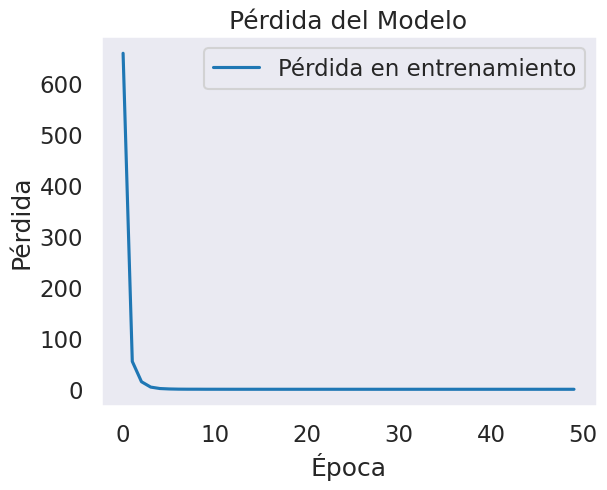

In [145]:
#Se pinta la perdida: rendimiento del modelo
#Se grafica cómo bajó el error durante el entrenamiento. Si la curva baja, el modelo está aprendiendo.

plt.plot(rendimiento_Mod_DL.history['loss'], label='Pérdida en entrenamiento')
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend()
plt.show()


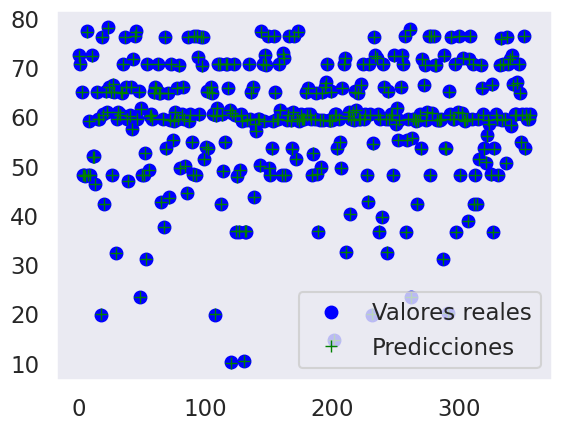

In [146]:
#Se pinta las predicciones sobre datos conocidos (entrenamiento)
plt.plot(y_train, 'bo', label='Valores reales')
plt.plot(pred_DL_Train, '+g', label='Predicciones')
plt.legend()
plt.show()


se puede Observar que el modelo se ajusta bastante bien a los datos puesto que  los valores reales (azul) con los predichos (verde) se acercan y se sobreponen,por lo que podemos concluir que el modelo esta prediciendo de manera correcta.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step 


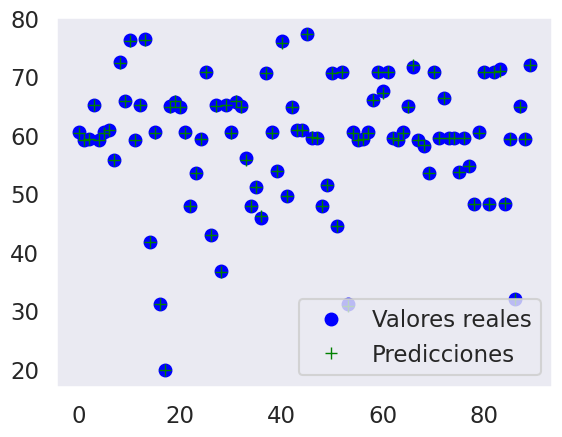

In [147]:
#Se pinta las predicciones sobre datos desconodicos (prueba)
pred_DL_Test = modelo_DL.predict(x_test)

plt.plot(y_test, 'bo', label='Valores reales')
plt.plot(pred_DL_Test, '+g', label='Predicciones')
plt.legend()
plt.show()


#**Predicción de la Calidad del Agua**

* Hasta ahora se predice el Indice de Calida de Agua.
* Se requiere clasificar el agua según el WQI que se predice y así predecir su calidad.
* Se crea un modelo de Regresión Logística para predecir valores por categorias.
* La columna 'CALIDAD' contiene formato 'string', se convierte a 'StringIndexer'
* Se crea un vector assembler para los datos del índice
* Se normaliza los valores en el vector

In [79]:
#Se convierte a spark dataframe
sparkDF = sqlContext.createDataFrame(pandasDF)

In [80]:
#Se Redondean las columnas que faltaban por redondear a 3 digitos
sparkDF = sparkDF.withColumn("TEMP", round(sparkDF["TEMP"], 3))
sparkDF = sparkDF.withColumn("DO", round(sparkDF["DO"], 3))
sparkDF = sparkDF.withColumn("ph", round(sparkDF["ph"], 3))
sparkDF = sparkDF.withColumn("BOD", round(sparkDF["BOD"], 3))
sparkDF = sparkDF.withColumn("NITRATE_N_NITRITE_N", round(sparkDF["NITRATE_N_NITRITE_N"], 3))
sparkDF = sparkDF.withColumn("FECAL_COLIFORM", round(sparkDF["FECAL_COLIFORM"], 3))


In [81]:
#vision del dataframe
sparkDF.show(5)

+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+----+----+------+-----+----+----+----+-----+-----+----+---+-----+------+--------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| ph|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFC| wph|  wDO|wCOND|wBOD|wNN|  wFC|   WQI| CALIDAD|
+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+----+----+------+-----+----+----+----+-----+-----+----+---+-----+------+--------+
|        1312|GODAVARI AT JAYAK...|Maharashtra|29.2|6.4|8.1|       735.0|3.4|                2.0|           3.0| 100| 100|     0|   80| 100| 100|16.5| 28.1|  0.0|0.72|2.8| 28.1| 76.22|Muy_Baja|
|        2177|GODAVARI RIVER NE...|Maharashtra|24.5|6.0|8.0|       270.0|3.1|                2.0|          72.0| 100| 100|    40|   80| 100|  60|16.5| 28.1|0.936|0.72|2.8|16.86|65.916|    Baja|
|        2182|GODAVARI RIVER A

In [82]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression

#Se crea el indexador
indexador = StringIndexer(inputCol='CALIDAD', outputCol='label')
vectorA2 = VectorAssembler(inputCols=['qrPH', 'qrDO', 'qrCOND', 'qrBOD', 'qrNN', 'qrFC','WQI'], outputCol='features2')
normalizar2 = Normalizer(inputCol='features2', outputCol='features_normalizada2', p=1.0)

In [83]:
#Se crea el modelo de Regresión Logística
modeloLogReg = LogisticRegression(featuresCol='features_normalizada2', labelCol='label', maxIter=10)

#Se crea el pipeline para aplicar las configuraciones
pipeline_B = Pipeline(stages=[indexador, vectorA2, normalizar2, modeloLogReg])

In [84]:
# Se dividen los datos para entrenamiento y prueba <se hace uso de la funcion randomSplit("division aleatoria" de sparkML)
train_data_B, test_data_B = sparkDF.randomSplit([0.8, 0.2], seed=11)

# Se implementa el modelo de Regresión Logística
Modelo_RL = pipeline_B.fit(train_data_B)

In [85]:
#### Predicción sobre entrenamiento
pred_train_2 = Modelo_RL.transform(train_data_B)

### Se observan
pred_train_2.select('label', 'prediction').show(20)

+-----+----------+
|label|prediction|
+-----+----------+
|  2.0|       2.0|
|  3.0|       3.0|
|  2.0|       2.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [86]:
#### Predicción sobre prueba
pred_test_2 = Modelo_RL.transform(test_data_B)

### Se observan
pred_test_2.select('label', 'prediction').show(20)

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



* Se revisa el rendimiento (métrica) del modelo RL

In [87]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluacion_RL = MulticlassClassificationEvaluator().setMetricName('accuracy').setPredictionCol('prediction').setLabelCol('label')
evaluacion_RL.evaluate(pred_train_2)


0.9944289693593314

In [88]:
print("El valor de accuracy es: %f" %evaluacion_RL.evaluate(pred_train_2))

El valor de accuracy es: 0.994429


el modelo tuvo un 99% de acierto en sus predicciones

* Como la columna "CALIDAD" esta en formato string (categorias), se convierten los valores que predicen a formato string y así compararlos en categorias.

In [89]:
##Se obtienen las categorias
sparkDF.select('CALIDAD').distinct().show()

+---------+
|  CALIDAD|
+---------+
|Excelente|
|    Buena|
| Muy_Baja|
|     Baja|
+---------+



In [90]:
categoria = ['Muy_Baja', 'Baja', 'Inadecuada', 'Excelente']

In [91]:
#Se crea una tabla temporal SQL

pred_train_2.createOrReplaceTempView("pred_train_2_sql")


In [92]:

pred_Cat = spark.sql("select prediction from pred_train_2_sql")
pred_Cat = pred_Cat.rdd.map(lambda fila: fila.prediction).collect()

calidadRL = spark.sql("select CALIDAD from pred_train_2_sql")
calidadRL = calidadRL.rdd.map(lambda fila: fila.CALIDAD).collect()

In [93]:
#Se presentan las primeras 20 predicciones del entrenamiento - Se compara con los datos Reales de entrenamiento
for x in range (20):
  print(f'Predicción T: {categoria[int(pred_Cat[x])]} \t  - \t Calidad Real: {calidadRL[x]}')


Predicción T: Inadecuada 	  - 	 Calidad Real: Muy_Baja
Predicción T: Excelente 	  - 	 Calidad Real: Excelente
Predicción T: Inadecuada 	  - 	 Calidad Real: Muy_Baja
Predicción T: Muy_Baja 	  - 	 Calidad Real: Baja
Predicción T: Muy_Baja 	  - 	 Calidad Real: Baja
Predicción T: Muy_Baja 	  - 	 Calidad Real: Baja
Predicción T: Baja 	  - 	 Calidad Real: Buena
Predicción T: Baja 	  - 	 Calidad Real: Buena
Predicción T: Baja 	  - 	 Calidad Real: Buena
Predicción T: Baja 	  - 	 Calidad Real: Buena
Predicción T: Muy_Baja 	  - 	 Calidad Real: Baja
Predicción T: Muy_Baja 	  - 	 Calidad Real: Baja
Predicción T: Baja 	  - 	 Calidad Real: Buena
Predicción T: Muy_Baja 	  - 	 Calidad Real: Baja
Predicción T: Baja 	  - 	 Calidad Real: Buena
Predicción T: Muy_Baja 	  - 	 Calidad Real: Baja
Predicción T: Baja 	  - 	 Calidad Real: Buena
Predicción T: Muy_Baja 	  - 	 Calidad Real: Baja
Predicción T: Muy_Baja 	  - 	 Calidad Real: Baja
Predicción T: Muy_Baja 	  - 	 Calidad Real: Baja


# Conclusiones del estudio

Durante este estudio basándose en los parámetros analizados y el cálculo del WQI, se logra observar que el agua en India tiende a clasificarse como de mala o de muy mala calidad. Durante este estudio se evidencio que las fuentes de Agua en muchos estados de India cuentan como factores de polucion posiblemente alto los cuales degradan la calidad del agua volviendola poco potable para un publico general. Esta observación muestra la importancia de implementar sistemas de monitoreo y predicción efectivos para tomar decisiones oportunas en materia ambiental y de salud pública.

El uso de modelos de Machine Learning (ML) permitió predecir el Índice de Calidad del Agua (WQI) con buena precisión. Estos modelos identifican patrones complejos entre múltiples variables, lo que resulta especialmente útil al manejar un Alto Volúmen De Datos ambientales. Las predicciones generadas tienden a confirmar la baja calidad del agua en muchas regiones.

Utilizamos estosmodelos de prediccion para el WQI porque anticipar problemas en la calidad del agua, facilitan la acción preventiva, y permiten la identificación de las regiones más vulnerables. Esto ayuda a diseñar políticas públicas más eficientes y sostenibles.

En conclusión, se cumplió el objetivo del estudio al desarrollar modelos predictivos confiables y al visualizar cómo varían parametros y la calidad del agua entre los estados.

# **Referencias**

* **[1]** Spellman FR. Handbook of Water and Wastewater Treatment Plant Operations. 3rd ed. Boca Raton: CRC Press; 2013.
* **[2]** Hassan Omer, N. (2020). Water Quality Parameters. IntechOpen. doi: 10.5772/intechopen.89657
* **[3]** Hammer MJ. Water and Wastewater Technology. 7th ed. Upper Saddle River: Pearson education; 2011.
* **[4]** Tchobanoglous G, Burton FL, Stensel HD. Metcalf & Eddy Wastewater Engineering: Treatment and Reuse. 4th ed. New Delhi: Tata McGraw-Hill Limited; 2003.
* **[5]** Alley ER. Water Quality Control Handbook. Vol. 2. New York: McGraw-Hill; 2007.

* **[6]** Nathanson JA. Basic Environmental Technology: Water Supply. New Delhi: Printice-Hall of India; 2004

* **[7]** Cirino, E. (2019) - What pH Should My Drinking Water Be?
https://www.healthline.com/health/ph-of-drinking-water

* **[8]** datascientest.com(S.F) - Keras: todo sobre la API de Deep Learning
https://datascientest.com/es/keras-la-api-de-deep-learning#:~:text=En%20la%20actualidad%2C%20Keras%20es,secuencia%20o%20un%20gr%C3%A1fico%20independiente.
